In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from itertools import product
import os, pickle

plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv(r"E:\data\stock_prices.csv",index_col="date",parse_dates=True)
df = df.sort_index()
print("Loaded real data:", df.shape)

Loaded real data: (1950, 10)


In [3]:
# ================================================================
# 1. Feature Builder (same as training)
# ================================================================
def compute_returns(px_df, kind="log"):
    return (np.log(px_df).diff() if kind=="log" else px_df.pct_change()).dropna()

def realized_vol(ret_df, window=20):
    return ret_df.rolling(window, min_periods=window).std()

def add_time_lags_df(df_in, lags=5, name_suffix=""):
    parts = [df_in.shift(k).add_suffix(f"{name_suffix}_t-{k}") for k in range(1, lags+1)]
    return pd.concat(parts, axis=1)

def build_features_target_next_price(px_df, lags=5, vol_windows=(5,20), include_level=True):
    ret = compute_returns(px_df, "log")
    px_aligned = px_df.loc[ret.index]

    X_ret = add_time_lags_df(ret, lags=lags, name_suffix="_r")
    X_vol = pd.concat([
        add_time_lags_df(realized_vol(ret,w), lags=min(3,lags), name_suffix=f"_vol{w}")
        for w in vol_windows
    ], axis=1)

    # volatility regime (3 binary indicators)
    mkt_vol = realized_vol(ret, window=vol_windows[0]).median(axis=1)
    q = mkt_vol.quantile([0.33,0.66])

    X_reg = pd.concat([
        (mkt_vol <= q.iloc[0]).astype(int).rename("reg_low"),
        ((mkt_vol>q.iloc[0])&(mkt_vol<=q.iloc[1])).astype(int).rename("reg_mid"),
        (mkt_vol>q.iloc[1]).astype(int).rename("reg_high")
    ], axis=1)

    parts = [X_ret, X_vol, X_reg]

    if include_level:
        X_lvl = add_time_lags_df(px_aligned - px_aligned.mean(), lags=min(2,lags), name_suffix="_lvl")
        parts.append(X_lvl)

    X = pd.concat(parts, axis=1).dropna()
    Y_next = px_aligned.shift(-1).reindex(X.index).dropna()
    X = X.loc[Y_next.index]

    return X, Y_next

In [4]:
# ------------------------------------------------------------
# 2) ESN MULTI CLASS
# ------------------------------------------------------------
class EchoStateNetworkMulti:
    def __init__(self, n_inputs, n_outputs,
                 n_res_fast=200, n_res_slow=200,
                 sr_fast=0.95, sr_slow=0.75,
                 leak_fast=0.30, leak_slow=0.15,
                 sparsity=0.90, input_scaling=1.0,
                 use_bias_in=True,
                 ext_bias_fast=0.0, ext_bias_slow=0.0,
                 add_input_to_readout=True,
                 ridge_alpha=1e-2,
                 noise=0.0, random_state=42, washout=0,
                 input_bias=None):

        self.n_inputs, self.n_outputs = n_inputs, n_outputs
        self.nf, self.ns = n_res_fast, n_res_slow
        self.sr_fast, self.sr_slow = sr_fast, sr_slow
        self.leak_f, self.leak_s = leak_fast, leak_slow
        self.sparsity, self.input_scaling = sparsity, input_scaling
        self.use_bias_in = use_bias_in
        self.ext_bias_f, self.ext_bias_s = float(ext_bias_fast), float(ext_bias_slow)
        self.add_input_to_readout = add_input_to_readout
        
        self.ridge_alpha = ridge_alpha
        self.washout = washout

        self.noise = noise
        self.rng = np.random.RandomState(random_state)

        if input_bias is not None:
            input_bias = np.asarray(input_bias, dtype=float)
            assert input_bias.shape == (n_inputs,)
        self.input_bias = input_bias

        self._init_weights()
        self.readout = Ridge(alpha=self.ridge_alpha, fit_intercept=False)

    def _init_weights(self):
        def init_block(n_res, sr):
            in_dim = self.n_inputs + (1 if self.use_bias_in else 0)
            Win = (self.rng.rand(n_res, in_dim) - 0.5) * 2.0 * self.input_scaling
            W = self.rng.rand(n_res, n_res) - 0.5
            W[self.rng.rand(n_res, n_res) < self.sparsity] = 0.0
            eigmax = np.max(np.abs(np.linalg.eigvals(W))) or 1e-6
            return Win, (W / eigmax) * sr
        self.Win_f, self.W_f = init_block(self.nf, self.sr_fast)
        self.Win_s, self.W_s = init_block(self.ns, self.sr_slow)

    def _run(self, X):
        T = X.shape[0]
        xf, xs = np.zeros(self.nf), np.zeros(self.ns)
        states = np.zeros((T, self.nf + self.ns))

        for t in range(T):
            u = X[t]
            if self.input_bias is not None:
                u = u + self.input_bias

            u_in = np.append(u, 1.0) if self.use_bias_in else u

            xf = (1 - self.leak_f) * xf + self.leak_f * np.tanh(self.Win_f @ u_in + self.W_f @ xf) + self.ext_bias_f
            xs = (1 - self.leak_s) * xs + self.leak_s * np.tanh(self.Win_s @ u_in + self.W_s @ xs) + self.ext_bias_s

            if self.noise:
                xf += self.noise * self.rng.randn(*xf.shape)
                xs += self.noise * self.rng.randn(*xs.shape)

            states[t] = np.concatenate([xf, xs])

        return states

    def fit(self, X, Y):
        S = self._run(X)
        ws = self.washout
        feats = [S[ws:]]
        if self.add_input_to_readout:
            feats.append(X[ws:])
        feats.append(np.ones((len(X) - ws, 1)))
        Phi = np.hstack(feats)
        self.readout.fit(Phi, Y[ws:])

    def predict(self, X):
        S = self._run(X)
        feats = [S]
        if self.add_input_to_readout:
            feats.append(X)
        feats.append(np.ones((len(X), 1)))
        Phi = np.hstack(feats)
        return self.readout.predict(Phi)

In [ ]:
# ------------------------------------------------------------
# 3) ROBUST LAG OPTIMIZER — SHARED ESN
#    Walk-forward + stability penalty
# ------------------------------------------------------------
def robust_lag_optimizer_shared(df, lag_range=range(5, 20),
                                n_splits=5, min_train=500,
                                step_test=50, random_state=42):

    out = []
    for L in lag_range:

        X_df, Y_df = build_features_target_next_price(df, lags=L)
        X, Y = X_df.values, Y_df.values
        n = len(X)
        if n < min_train + step_test + 10:
            continue

        split_points = np.linspace(min_train, n-step_test, n_splits, dtype=int)

        rmses = []
        for sp in split_points:

            X_train, X_test = X[:sp], X[sp:sp+step_test]
            Y_train, Y_test = Y[:sp], Y[sp:sp+step_test]

            scX = StandardScaler().fit(X_train)
            scY = StandardScaler().fit(Y_train)
            Xtr, Xte = scX.transform(X_train), scX.transform(X_test)
            Ytr = scY.transform(Y_train)

            esn = EchoStateNetworkMulti(
                n_inputs=Xtr.shape[1],
                n_outputs=Ytr.shape[1],
                n_res_fast=200, n_res_slow=200,
                sr_fast=0.95, sr_slow=0.80,
                leak_fast=0.30, leak_slow=0.15,
                sparsity=0.90, input_scaling=1.0,
                use_bias_in=True,
                ridge_alpha=1e-2,washout=0,
                noise=0.0, random_state=random_state
            )

            esn.fit(Xtr, Ytr)
            Yhat_sc = esn.predict(Xte)
            Yhat = scY.inverse_transform(Yhat_sc)

            rmse = np.sqrt(mean_squared_error(Y_test.flatten(), Yhat.flatten()))
            rmses.append(rmse)

        rmse_mean = float(np.mean(rmses))
        rmse_std  = float(np.std(rmses))
        penalty   = rmse_mean + 0.5*rmse_std

        print(f"Lag={L:2d} | RMSE={rmse_mean:.4f} | STD={rmse_std:.4f} | Penalty={penalty:.4f}")
        out.append((L, rmse_mean, rmse_std, penalty))

    best = min(out, key=lambda x: x[3])
    best_L = best[0]
    table = pd.DataFrame(out, columns=["Lag","RMSE","STD","Penalty"]).set_index("Lag")

    print("ROBUST BEST LAG =", best_L)


    return best_L, table

Shapes: X_train=(1348, 263), X_val=(289, 263), X_test=(289, 263)
Targets: Y_train=(1348, 10), Y_val=(289, 10), Y_test=(289, 10)
Sequence X_trv_seq: (1617, 20, 263)
Sequence X_te_seq : (269, 20, 263)
Seq Y_trv_seq     : (1617, 10)
Seq Y_te_seq      : (269, 10)

=== TRAINING SHARED ESN ON SEQUENCES ===

=== MODEL 2 — Shared ESN (SEQUENCE version) ===
Robust Lag (features): 18
SEQ window length    : 20
RMSE overall: 16.605
MAE  overall: 11.133
R²   overall: 0.990

Per-asset metrics (sequence ESN):
           RMSE        MAE        R²
SCHD   0.773569   0.600822  0.109121
VZ     1.499104   1.195097  0.387087
PG     5.939458   4.685392 -0.057435
CVX    6.197806   4.816332  0.447774
XOM    6.399674   5.374412 -0.767176
MSFT  18.161152  15.054020  0.845557
CAT   18.729259  14.665522  0.805744
AMZN  20.991063  18.711021 -0.370446
VOO   21.139080  18.239980  0.567846
AVGO  32.735971  27.982888  0.657095


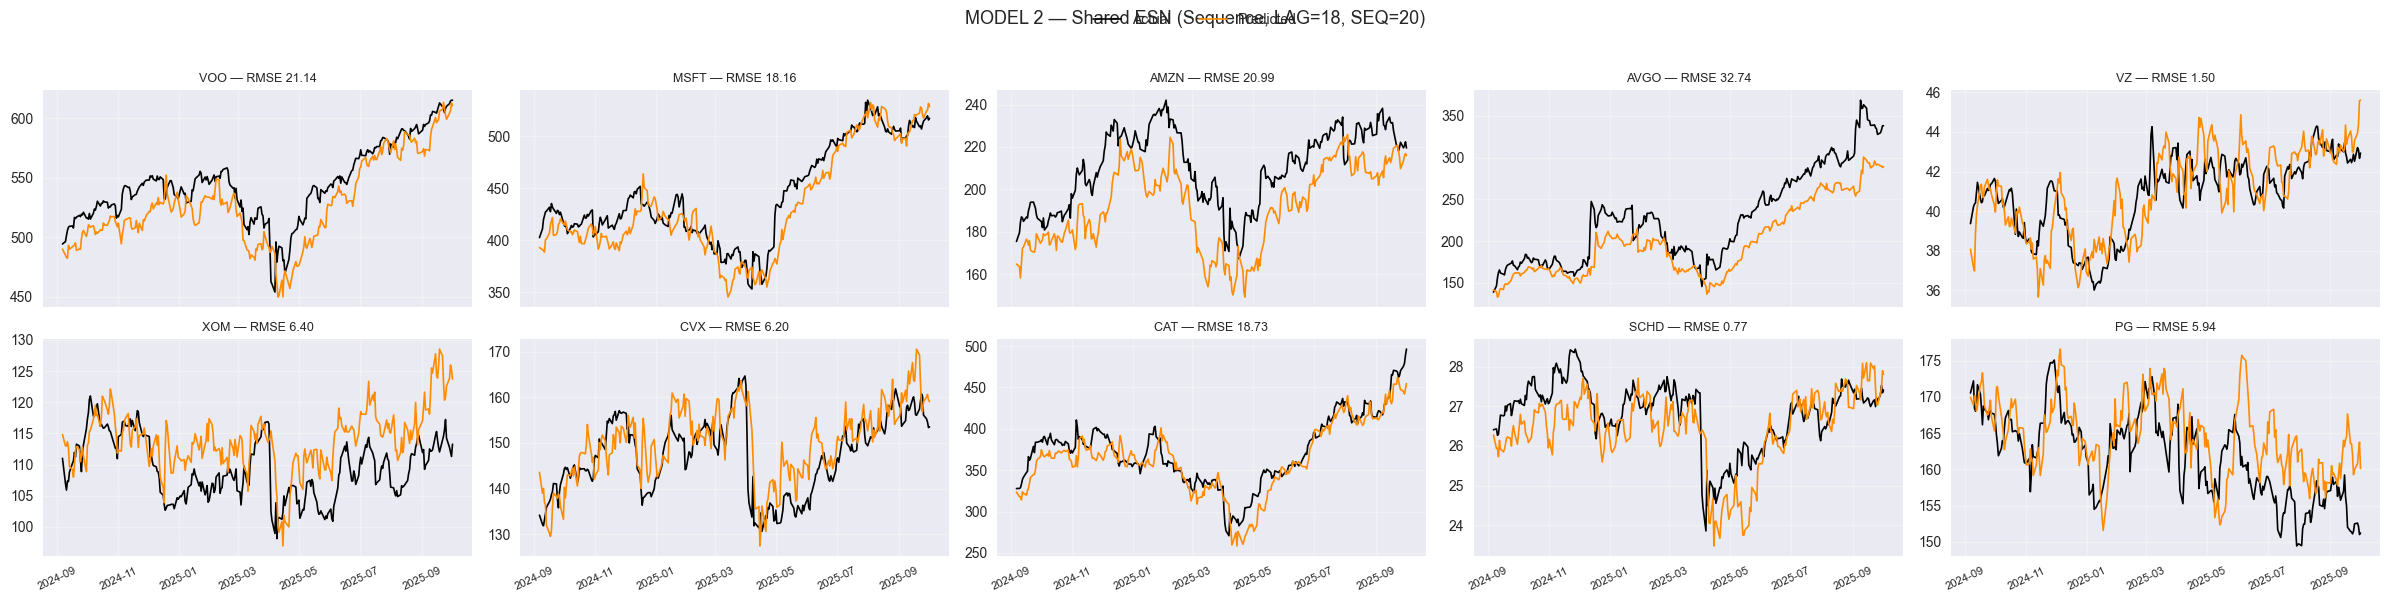

In [ ]:
# ------------------------------------------------------------
# 6) BUILD DATASETS WITH best_L  
# ------------------------------------------------------------
X_df, Y_df = build_features_target_next_price(df, lags=best_L)

n = len(X_df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

X_train, X_val, X_test = X_df.iloc[:train_end], X_df.iloc[train_end:val_end], X_df.iloc[val_end:]
Y_train, Y_val, Y_test = Y_df.iloc[:train_end], Y_df.iloc[train_end:val_end], Y_df.iloc[val_end:]

X_trv = pd.concat([X_train, X_val])
Y_trv = pd.concat([Y_train, Y_val])

idx_test = X_test.index
cols_Y   = Y_df.columns.tolist()

print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
print(f"Targets: Y_train={Y_train.shape}, Y_val={Y_val.shape}, Y_test={Y_test.shape}")

# ------------------------------------------------------------
# 7) SCALING
# ------------------------------------------------------------
scX = StandardScaler().fit(X_trv)
scY = StandardScaler().fit(Y_trv)

X_trv_sc = scX.transform(X_trv)
X_te_sc  = scX.transform(X_test)
Y_trv_sc = scY.transform(Y_trv)

# ------------------------------------------------------------
# 8) SEQUENCE WINDOWS 
# ------------------------------------------------------------
SEQ = 20  

def make_sequence_windows(X, seq_len):
    """
    X: (T, n_features)
    return: (N_seq, seq_len, n_features)
    """
    X = np.asarray(X)
    T = X.shape[0]
    out = []
    for i in range(T - seq_len):
        out.append(X[i:i+seq_len])
    return np.stack(out, axis=0)

X_trv_seq = make_sequence_windows(X_trv_sc, SEQ)  # (N_trv_seq, SEQ, d)
Y_trv_seq = Y_trv_sc[SEQ:]    # (N_trv_seq, n_assets)

X_te_seq  = make_sequence_windows(X_te_sc, SEQ)   # (N_te_seq, SEQ, d)
Y_te_seq  = Y_test.values[SEQ:]   # (N_te_seq, n_assets)

idx_test_seq = idx_test[SEQ:]        

print("Sequence X_trv_seq:", X_trv_seq.shape)
print("Sequence X_te_seq :", X_te_seq.shape)
print("Seq Y_trv_seq     :", Y_trv_seq.shape)
print("Seq Y_te_seq      :", Y_te_seq.shape)

# ------------------------------------------------------------
# 9) train / predict in sequence windows
# ------------------------------------------------------------
def esn_fit_on_sequences(model, X_seq, Y_seq):
    N, L, d = X_seq.shape
    # --- initialize states ---
    xf = np.zeros(model.nf)
    xs = np.zeros(model.ns)

    feats = []

    for i in range(N):
        Xw = X_seq[i]

        for t in range(L):
            u = Xw[t]
            u_in = np.append(u, 1.0) if model.use_bias_in else u

            xf = (1 - model.leak_f)*xf + model.leak_f*np.tanh(model.Win_f @ u_in + model.W_f @ xf)
            xs = (1 - model.leak_s)*xs + model.leak_s*np.tanh(model.Win_s @ u_in + model.W_s @ xs)

        # last state of this window (stateful)
        last_state = np.concatenate([xf, xs])

        row = [last_state]
        if model.add_input_to_readout:
            row.append(Xw[-1])
        row.append(np.ones(1))

        feats.append(np.concatenate(row))

    Phi = np.vstack(feats)
    model.readout.fit(Phi, Y_seq)

def esn_predict_on_sequences(model, X_seq):
    
    N, L, d = X_seq.shape

    xf = np.zeros(model.nf)
    xs = np.zeros(model.ns)
    feats = []

    for i in range(N):
        Xw = X_seq[i]

        # run stateful window
        for t in range(L):
            u = Xw[t]
            u_in = np.append(u, 1.0) if model.use_bias_in else u
            xf = (1 - model.leak_f)*xf + model.leak_f*np.tanh(model.Win_f @ u_in + model.W_f @ xf)
            xs = (1 - model.leak_s)*xs + model.leak_s*np.tanh(model.Win_s @ u_in + model.W_s @ xs)

        last_state = np.concatenate([xf, xs])

        row = [last_state]
        if model.add_input_to_readout:
            row.append(Xw[-1])
        row.append(np.ones(1))

        feats.append(np.concatenate(row))

    Phi = np.vstack(feats)
    return model.readout.predict(Phi)

# ------------------------------------------------------------
# 10) TRAIN FINAL SHARED ESN in SEQUENCE WINDOWS
# ------------------------------------------------------------
esn_multi = EchoStateNetworkMulti(
    n_inputs=X_trv_sc.shape[1],
    n_outputs=len(cols_Y),
    n_res_fast=180, n_res_slow=180,
    sr_fast=0.95, sr_slow=0.80,
    leak_fast=0.30, leak_slow=0.15,
    sparsity=0.90, input_scaling=1.0,
    use_bias_in=True,
    ext_bias_fast=0.0, ext_bias_slow=0.0,
    add_input_to_readout=True,
    ridge_alpha=1e-2,
    washout=0,          
    noise=0.0,
    random_state=42
)

print("\n=== TRAINING SHARED ESN ON SEQUENCES ===")
esn_fit_on_sequences(esn_multi, X_trv_seq, Y_trv_seq)

Y_hat_sc_seq = esn_predict_on_sequences(esn_multi, X_te_seq)
Y_hat_seq    = scY.inverse_transform(Y_hat_sc_seq)
Y_true_seq   = Y_te_seq

# ------------------------------------------------------------
# 11) METRICS
# ------------------------------------------------------------
rmse_overall = np.sqrt(mean_squared_error(Y_true_seq.flatten(), Y_hat_seq.flatten()))
mae_overall  = mean_absolute_error(Y_true_seq.flatten(), Y_hat_seq.flatten())
r2_overall   = r2_score(Y_true_seq.flatten(), Y_hat_seq.flatten())

print("\n=== MODEL 2 — Shared ESN (SEQUENCE version) ===")
print(f"Robust Lag (features): {best_L}")
print(f"SEQ window length    : {SEQ}")
print(f"RMSE overall: {rmse_overall:.3f}")
print(f"MAE  overall: {mae_overall:.3f}")
print(f"R²   overall: {r2_overall:.3f}")

rmse_per = np.sqrt(((Y_true_seq - Y_hat_seq) ** 2).mean(axis=0))
mae_per  = np.abs(Y_true_seq - Y_hat_seq).mean(axis=0)
r2_per   = [r2_score(Y_true_seq[:, i], Y_hat_seq[:, i]) for i in range(len(cols_Y))]

metrics_df = pd.DataFrame(
    {"RMSE": rmse_per, "MAE": mae_per, "R²": r2_per},
    index=cols_Y
).sort_values("RMSE")

print("\nPer-asset metrics (sequence ESN):")
print(metrics_df)

# ------------------------------------------------------------
# 12) PLOTS 
# ------------------------------------------------------------
ncols = 5
nrows = math.ceil(len(cols_Y) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 3*nrows), sharex=True)
axes = np.ravel(axes)

for i, col in enumerate(cols_Y):
    ax = axes[i]
    ax.plot(idx_test_seq, Y_true_seq[:, i], lw=1.2, color="black",      label="Actual")
    ax.plot(idx_test_seq, Y_hat_seq[:,  i], lw=1.2, color="darkorange", label="Predicted")
    ax.set_title(f"{col} — RMSE {rmse_per[i]:.2f}", fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=25, labelsize=8)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
fig.suptitle(f"MODEL 2 — Shared ESN (Sequence, LAG={best_L}, SEQ={SEQ})",
             y=0.995, fontsize=13)
plt.tight_layout(rect=(0,0,1,0.97))
plt.show()


In [ ]:
param_grid = {
    "n_res_fast":  [10,20,30,40,50,60,70,80,90,100,120, 180, 240,300,400],
    "n_res_slow":  [10,20,30,40,50,60,70,80,90,100, 120, 180, 240],
    "sr_fast":     [0.90, 0.95, 1.00],
    "sr_slow":     [0.70, 0.80, 0.90],
    "leak_fast":   [0.10, 0.30],
    "leak_slow":   [0.05, 0.15],
    "ridge_alpha": [1e-3, 1e-2, 3e-2]
}


def evaluate_config_seq(params, X_trv_seq, Y_trv_seq, X_val_seq, Y_val_seq, scY):
    esn = EchoStateNetworkMulti(
        n_inputs = X_trv_seq.shape[2],
        n_outputs = Y_trv_seq.shape[1],
        n_res_fast = params["n_res_fast"],
        n_res_slow = params["n_res_slow"],
        sr_fast = params["sr_fast"],
        sr_slow = params["sr_slow"],
        leak_fast = params["leak_fast"],
        leak_slow = params["leak_slow"],
        sparsity = 0.90,
        input_scaling = 1.0,
        use_bias_in = True,
        ext_bias_fast = 0.0,
        ext_bias_slow = 0.0,
        add_input_to_readout = True,
        ridge_alpha = params["ridge_alpha"],
        washout = 0,      
        noise = 0.0,
        random_state = 42
    )

    esn_fit_on_sequences(esn, X_trv_seq, Y_trv_seq)

    Yhat_sc = esn_predict_on_sequences(esn, X_val_seq)
    Yhat = scY.inverse_transform(Yhat_sc)

    rmse = np.sqrt(((Y_val_seq - Yhat)**2).mean())
    return rmse

print("\n Starting SEQUENCE Grid Search...\n")

all_combos = list(product(*param_grid.values()))
np.random.seed(0)
subset = np.random.choice(len(all_combos), size=60, replace=False)

results = []
keys = list(param_grid.keys())

for idx in subset:
    combo = all_combos[idx]
    params = dict(zip(keys, combo))

    rmse = evaluate_config_seq(
        params,
        X_trv_seq, Y_trv_seq,
        X_te_seq,  Y_te_seq,
        scY
    )
    results.append((rmse, params))
    print(f"RMSE={rmse:.4f} | {params}")

best_rmse, best_params = min(results, key=lambda x: x[0])

print("\n========================")
print("BEST CONFIG (SEQUENCE ESN):")
print(best_params)
print("RMSE =", best_rmse)
print("========================")

BEST = best_params


 Starting SEQUENCE Grid Search...

RMSE=15.0981 | {'n_res_fast': 10, 'n_res_slow': 40, 'sr_fast': 0.95, 'sr_slow': 0.7, 'leak_fast': 0.3, 'leak_slow': 0.05, 'ridge_alpha': 0.001}
RMSE=23.2315 | {'n_res_fast': 100, 'n_res_slow': 70, 'sr_fast': 0.9, 'sr_slow': 0.9, 'leak_fast': 0.1, 'leak_slow': 0.05, 'ridge_alpha': 0.01}
RMSE=16.3664 | {'n_res_fast': 70, 'n_res_slow': 180, 'sr_fast': 0.9, 'sr_slow': 0.9, 'leak_fast': 0.3, 'leak_slow': 0.15, 'ridge_alpha': 0.001}
RMSE=16.9985 | {'n_res_fast': 300, 'n_res_slow': 180, 'sr_fast': 1.0, 'sr_slow': 0.7, 'leak_fast': 0.3, 'leak_slow': 0.15, 'ridge_alpha': 0.01}
RMSE=23.1414 | {'n_res_fast': 180, 'n_res_slow': 80, 'sr_fast': 0.95, 'sr_slow': 0.7, 'leak_fast': 0.1, 'leak_slow': 0.05, 'ridge_alpha': 0.01}
RMSE=17.2426 | {'n_res_fast': 100, 'n_res_slow': 120, 'sr_fast': 1.0, 'sr_slow': 0.7, 'leak_fast': 0.1, 'leak_slow': 0.15, 'ridge_alpha': 0.03}
RMSE=13.3671 | {'n_res_fast': 80, 'n_res_slow': 90, 'sr_fast': 0.95, 'sr_slow': 0.8, 'leak_fast': 0.3

In [8]:
BEST = {
    "n_res_fast": 50,
    "n_res_slow": 40,
    "sr_fast": 0.95,
    "sr_slow": 0.7,
    "leak_fast": 0.30,
    "leak_slow": 0.15,
    "ridge_alpha": 0.03
}

best_L_2 = 11  
SEQ = 5    


=== TRAINING FINAL SEQUENCE ESN ===


=== FINAL SEQUENCE ESN RESULTS ===
Best Lag        : 11
SEQ window      : 5
RMSE (overall)  : 11.385
MAE (overall)   : 7.668
R^2 (overall)    : 0.995


,RMSE,MAE,R^2
SCHD,0.672,0.527,0.302
VZ,1.740,1.406,0.219
PG,3.960,3.089,0.522
XOM,8.136,6.680,-1.947
CVX,8.162,6.496,0.045
AMZN,11.378,9.416,0.644
VOO,11.914,8.751,0.867
MSFT,14.374,11.494,0.900
AVGO,17.881,13.906,0.900
CAT,18.612,14.918,0.805


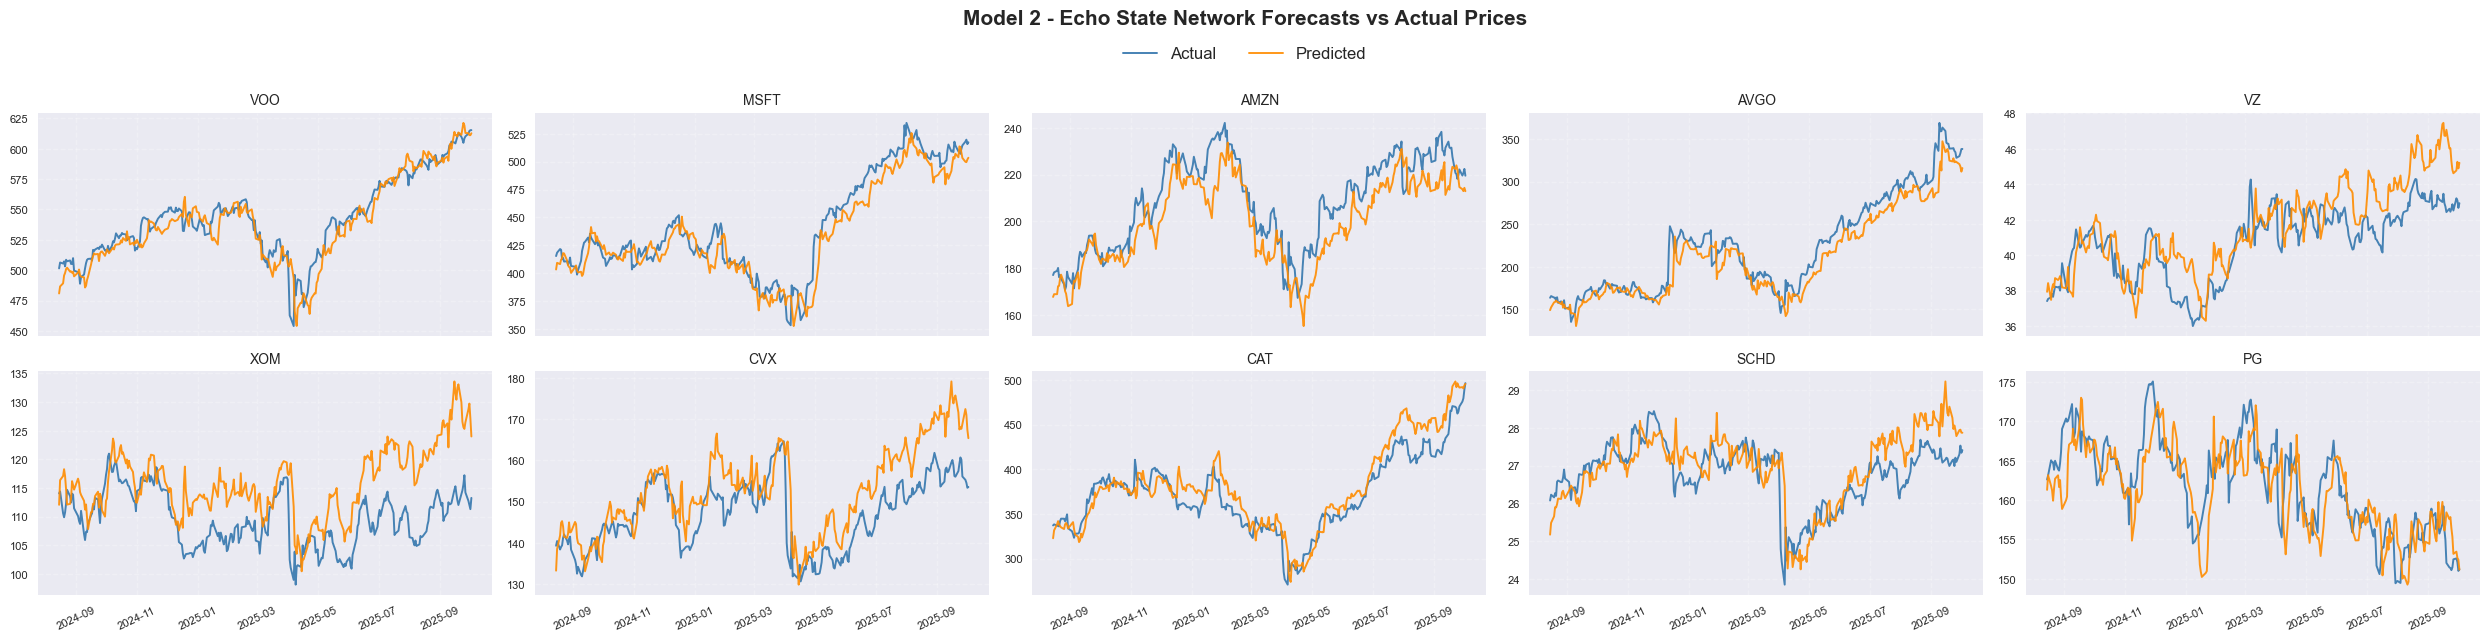

In [9]:
# =========================
# 2) BUILD DATASET
# =========================
X_df, Y_df = build_features_target_next_price(df, lags=best_L_2)

n = len(X_df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train, X_val, X_test = (
    X_df.iloc[:train_end],
    X_df.iloc[train_end:val_end],
    X_df.iloc[val_end:]
)

Y_train, Y_val, Y_test = (
    Y_df.iloc[:train_end],
    Y_df.iloc[train_end:val_end],
    Y_df.iloc[val_end:]
)

X_trv = pd.concat([X_train, X_val])
Y_trv = pd.concat([Y_train, Y_val])

cols_Y = Y_df.columns.tolist()
idx_test = X_test.index

# =========================
# 3) SCALE
# =========================
scX = StandardScaler().fit(X_trv)
scY = StandardScaler().fit(Y_trv)

X_trv_sc = scX.transform(X_trv)
X_te_sc  = scX.transform(X_test)
Y_trv_sc = scY.transform(Y_trv)


# =========================
# 4) SEQUENCE WINDOWS
# =========================
def make_sequence_windows(X, seq_len):
    X = np.asarray(X)
    T = X.shape[0]
    return np.stack([X[i:i+seq_len] for i in range(T - seq_len)], axis=0)

X_trv_seq = make_sequence_windows(X_trv_sc, SEQ)
Y_trv_seq = Y_trv_sc[SEQ:]

X_te_seq  = make_sequence_windows(X_te_sc, SEQ)
Y_te_seq  = Y_test.values[SEQ:]

idx_test_seq = idx_test[SEQ:]

# =========================
# 5) TRAIN FINAL SEQUENCE ESN
# =========================
esn_multi = EchoStateNetworkMulti(
    n_inputs  = X_trv_seq.shape[2],
    n_outputs = Y_trv_seq.shape[1],
    n_res_fast = BEST["n_res_fast"],
    n_res_slow = BEST["n_res_slow"],
    sr_fast = BEST["sr_fast"],
    sr_slow = BEST["sr_slow"],
    leak_fast = BEST["leak_fast"],
    leak_slow = BEST["leak_slow"],
    sparsity=0.90,
    input_scaling=1.0,
    use_bias_in=True,
    ridge_alpha=BEST["ridge_alpha"],
    washout=0,                   
    random_state=42
)

print("\n=== TRAINING FINAL SEQUENCE ESN ===\n")
esn_fit_on_sequences(esn_multi, X_trv_seq, Y_trv_seq)

Y_hat_sc_seq = esn_predict_on_sequences(esn_multi, X_te_seq)
Y_hat_seq = scY.inverse_transform(Y_hat_sc_seq)
Y_true_seq = Y_te_seq

# =========================
# 6) METRICS
# =========================
rmse_overall = np.sqrt(mean_squared_error(Y_true_seq.flatten(),
                                          Y_hat_seq.flatten()))
mae_overall  = mean_absolute_error(Y_true_seq.flatten(),
                                   Y_hat_seq.flatten())
r2_overall   = r2_score(Y_true_seq.flatten(),
                        Y_hat_seq.flatten())

print("\n=== FINAL SEQUENCE ESN RESULTS ===")
print(f"Best Lag        : {best_L_2}")
print(f"SEQ window      : {SEQ}")
print(f"RMSE (overall)  : {rmse_overall:.3f}")
print(f"MAE (overall)   : {mae_overall:.3f}")
print(f"R^2 (overall)    : {r2_overall:.3f}")

rmse_vec = np.sqrt(((Y_true_seq - Y_hat_seq)**2).mean(axis=0))
mae_vec  = np.abs(Y_true_seq - Y_hat_seq).mean(axis=0)
r2_vec   = [r2_score(Y_true_seq[:, i],
                     Y_hat_seq[:, i])
            for i in range(Y_true_seq.shape[1])]

metrics_df = pd.DataFrame(
    {"RMSE": rmse_vec, "MAE": mae_vec, "R^2": r2_vec},
    index=cols_Y
).sort_values("RMSE")

display(metrics_df.style.background_gradient(cmap="coolwarm").format("{:.3f}"))

# =========================
# 7) PLOTS
# =========================
ncols = 5
nrows = math.ceil(len(cols_Y) / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5*ncols, 3.2*nrows),
    sharex=True
)

axes = np.ravel(axes)

for i, col in enumerate(cols_Y):
    ax = axes[i]
    ax.plot(idx_test_seq, Y_true_seq[:, i],lw=1.4, color="steelblue", label="Actual")
    ax.plot(idx_test_seq, Y_hat_seq[:, i],lw=1.4, color="darkorange", alpha=0.9, label="Predicted")
    ax.set_title(col, fontsize=10)
    ax.grid(True, alpha=0.25, linestyle="--")
    ax.tick_params(axis="x", rotation=25, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

# remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# global legend (clean placement)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center",bbox_to_anchor=(0.5, 0.96),ncol=2,frameon=False,fontsize=12)
fig.suptitle(f"Model 2 - Echo State Network Forecasts vs Actual Prices",fontsize=15,fontweight="bold",y=0.995)
plt.tight_layout(rect=(0,0,1,0.94))
plt.show()

In [11]:
total_params = (
    esn_multi.Win_f.size +
    esn_multi.W_f.size +
    esn_multi.Win_s.size +
    esn_multi.W_s.size +
    esn_multi.readout.coef_.size
)

print(f"Total parameters: {total_params:,}")

Total parameters: 24,400


In [ ]:
start_time = time.time()

end_time = time.time()
print(f"\nTraining time: {end_time - start_time:.2f} seconds")

def esn_model_size_mb(model):
    size = 0
    
    size += model.Win_f.nbytes
    size += model.W_f.nbytes
    
    size += model.Win_s.nbytes
    size += model.W_s.nbytes
    
    if hasattr(model.readout, "coef_"):
        size += model.readout.coef_.nbytes
    
    return size / (1024**2)

print(f"Model size: {esn_model_size_mb(esn_multi):.2f} MB")

print("\n=== TRAINING FINAL SEQUENCE ESN ===\n")

start_time = time.time()

esn_fit_on_sequences(esn_multi, X_trv_seq, Y_trv_seq)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")
print(f"Model size: {esn_model_size_mb(esn_multi):.2f} MB")
print(f"Trainable parameters: {esn_multi.readout.coef_.size:,}")


Training time: 0.00 seconds
Model size: 0.19 MB

=== TRAINING FINAL SEQUENCE ESN ===

Training time: 0.17 seconds
Model size: 0.19 MB
Trainable parameters: 2,840


In [ ]:
# ===========================================================
# === GRID SEARCH FOR BEST SEQ WINDOW ========================
# ===========================================================

SEQ_grid = [5, 10, 15, 20, 30, 40]  
results_seq = []

for SEQ_try in SEQ_grid:
    print(f"\nTesting SEQ={SEQ_try}")

    X_trv_seq_try = make_sequence_windows(X_trv_sc, SEQ_try)
    Y_trv_seq_try = Y_trv_sc[SEQ_try:]

    X_val_seq_try = make_sequence_windows(X_te_sc, SEQ_try)
    Y_val_seq_try = Y_test.values[SEQ_try:]

    esn_tmp = EchoStateNetworkMulti(
        n_inputs  = X_trv_seq_try.shape[2],
        n_outputs = Y_trv_seq_try.shape[1],
        n_res_fast = 30,
        n_res_slow = 30,
        sr_fast = 0.9,
        sr_slow = 0.8,
        leak_fast = 0.3,
        leak_slow = 0.15,
        sparsity=0.9,
        input_scaling=1.0,
        ridge_alpha=1e-2,
        washout=0,
        random_state=42
    )

    esn_fit_on_sequences(esn_tmp, X_trv_seq_try, Y_trv_seq_try)

    Y_val_sc = esn_predict_on_sequences(esn_tmp, X_val_seq_try)
    Y_val_hat = scY.inverse_transform(Y_val_sc)

    rmse_seq = np.sqrt(((Y_val_seq_try - Y_val_hat)**2).mean())
    results_seq.append((SEQ_try, rmse_seq))

    print(f"SEQ={SEQ_try}, RMSE={rmse_seq:.4f}")

best_SEQ, best_rmse_seq = min(results_seq, key=lambda x: x[1])

print("\n============================")
print("BEST SEQ WINDOW LENGTH:")
print(f"SEQ={best_SEQ}, RMSE={best_rmse_seq:.4f}")
print("============================")



Testing SEQ=5
SEQ=5, RMSE=10.4237

Testing SEQ=10
SEQ=10, RMSE=11.0187

Testing SEQ=15
SEQ=15, RMSE=11.2008

Testing SEQ=20
SEQ=20, RMSE=11.2041

Testing SEQ=30
SEQ=30, RMSE=11.3854

Testing SEQ=40
SEQ=40, RMSE=11.5357

BEST SEQ WINDOW LENGTH:
SEQ=5, RMSE=10.4237


In [14]:
print("\n================ MODEL 2 — SHARED ESN (SEQUENCE) ===================")

# DATASET SPLIT
print("\n--- Dataset split (days) ---")
print("Train+Val days :", X_trv.shape[0])
print("Test days      :", X_test.shape[0])
print("Assets         :", Y_df.shape[1])

# FEATURES
n_assets = Y_df.shape[1]

print("\n--- Feature engineering components (per timestep Z_t) ---")
print("Return lags (log-returns)       :", n_assets * best_L_2)
print("Volatility lags (vol5, vol20)   :", n_assets * min(3,best_L_2) * 2)
print("Volatility regime dummies       :", 3)
print("Price level lags                :", n_assets * min(2,best_L_2))

print("---------------------------------------------------------")
print("TOTAL engineered features Z_t   :", X_df.shape[1])

# RAW FEATURES
print("\n--- Raw feature matrix ---")
print("X_trv shape (time, Z_t) :", X_trv.shape)
print("X_test shape (time, Z_t):", X_test.shape)
print("Feature dimension Z_t   :", X_trv.shape[1])

# SEQUENCES
print("\n--- Sequence window construction ---")
print("Sequence length (SEQ)   :", SEQ)
print("X_trv_seq shape (N,SEQ,Z_t):", X_trv_seq.shape)
print("X_te_seq  shape (N,SEQ,Z_t):", X_te_seq.shape)

# ESN STRUCTURE
print("\n--- ESN internal structure ---")
print("Fast reservoir units    :", esn_multi.nf)
print("Slow reservoir units    :", esn_multi.ns)
print("Total state dim         :", esn_multi.nf + esn_multi.ns)

extra = X_trv_seq.shape[2] if esn_multi.add_input_to_readout else 0
readout_dim = esn_multi.nf + esn_multi.ns + extra + 1

print("Readout dimension Φ     :", readout_dim)

# TARGETS
print("\n--- Targets ---")
print("Y_trv_seq shape :", Y_trv_seq.shape)
print("Y_te_seq shape  :", Y_te_seq.shape)

print("\n===============================================================")


================ MODEL 2 — SHARED ESN (SEQUENCE) ===================

--- Dataset split (days) ---
Train+Val days : 1637
Test days      : 289
Assets         : 10

--- Feature engineering components (per timestep Z_t) ---
Return lags (log-returns)       : 110
Volatility lags (vol5, vol20)   : 60
Volatility regime dummies       : 3
Price level lags                : 20
---------------------------------------------------------
TOTAL engineered features Z_t   : 193

--- Raw feature matrix ---
X_trv shape (time, Z_t) : (1637, 193)
X_test shape (time, Z_t): (289, 193)
Feature dimension Z_t   : 193

--- Sequence window construction ---
Sequence length (SEQ)   : 5
X_trv_seq shape (N,SEQ,Z_t): (1632, 5, 193)
X_te_seq  shape (N,SEQ,Z_t): (284, 5, 193)

--- ESN internal structure ---
Fast reservoir units    : 50
Slow reservoir units    : 40
Total state dim         : 90
Readout dimension Φ     : 284

--- Targets ---
Y_trv_seq shape : (1632, 10)
Y_te_seq shape  : (284, 10)



In [ ]:
#SAVE_DIR = r"E:\models\ESN_Model2_ALIGNED"
os.makedirs(SAVE_DIR, exist_ok=True)

save_dict = {
    "model": esn_multi,
    "scX": scX,                
    "scY": scY,
    "assets": cols_Y,
    "LAGS": int(best_L_2),
    "SEQ": int(SEQ),            
    "X_columns": X_df.columns.tolist()
}

with open(os.path.join(SAVE_DIR, "ESN_Model2_full.pkl"), "wb") as f:
    pickle.dump(save_dict, f)

print("Model 2 saved in ESN_Model2_ALIGNED")